<a href="https://colab.research.google.com/github/ardayekh/ProfessionalDataEngineer/blob/main/Building_Batch_Data_Pipelines_on_GCP_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color="red">**--------------------[Week2 - Day1]--------------------**

<font color='green'>**Video#1: Introduction**
- Cloud Data Fusion is a a graphical UI used to build pipelines
- Cloud Data Fusion uses Cloud Dataproc cluster to perform all transforms in the pipeline
- Cloud data fusion is designed for batch pipelines
- Cloud Data Fusion translates your visually built pipeline into an Apache Spark or MapReduce program that executes transformations on an ephemeral Cloud Dataproc cluster in parallel. 
- When you run a pipeline, Cloud Data Fusion provisions an ephemeral Cloud Dataproc cluster, runs the pipeline, and then tears down the cluster.

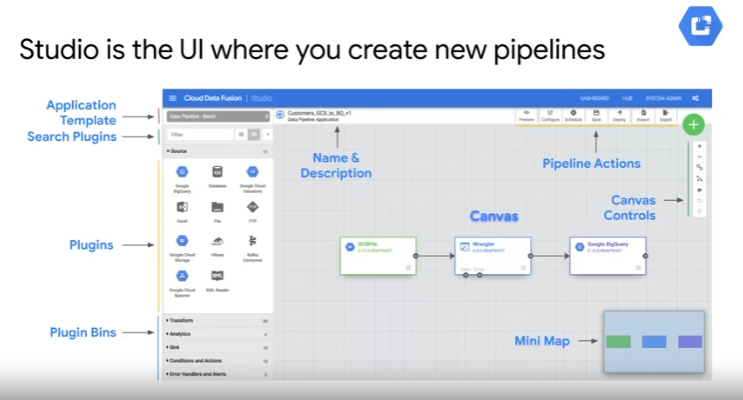

- you can create DAGs that represent pipelines in the canvas menu of the Studio
- Clicking on a node (a step in the pipeline) shows you the input & output of that step along with any errors
- You can integrate Google APIs with these pipelines (such as speech to text API)
- You can alse schedule you pipeline to run at ceratin intervals
- Cloud Data fusion provides the ability to capture data lineage by tracking every transform operation that is applied to each field
- The Wrangler UI is the Cloud Data Fusion environment for exploring new data sets visually for insights. Here, you can inspect the data set and build a series of transformation steps called directives to sticks together a pipeline.

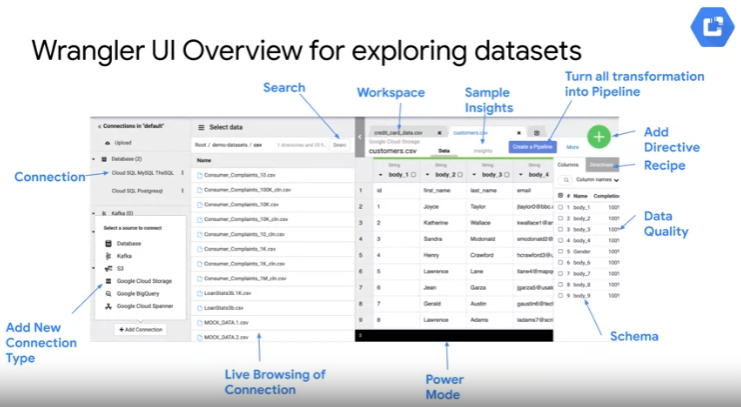

Lab:

Task 1: Creating a Cloud Data Fusion instance: Enable the Cloud Fusion API and create a new instance

Task 2: Loading the data: Create a GS bucket and copy sample data from public dataset into bucket

Task 3: Cleaning the data: Use the Wrangler UI in Cloud Data Fusion instance you created to transform data

Task 4: Creating the pipeline: Create a new pipleine in the Cloud Datafusion instance UI

Task 5: Adding a data source: Add BigQuery Source DAG node and set it up with information of storage table with sample data

Task 6: Joining two sources: Use a Joiner node to join the sample source data with another bigquery table that contains additonal info used to enrich the sample data for analytics

Task 7: Storing the output to BigQuery: Choose a bigquery sink node and set it up with new table that will house pipeline output data

Task 8: Deploying and running the pipeline: Deploy then Run the pipeline - This could take a few minutes. You can observe the status of the pipeline transition from Provisioning to Starting and from Starting to Running to Succeeded during this time.

Task 9: Viewing the results: View the outputted data in the new Bigquery table created by the pipeline and query it for insights


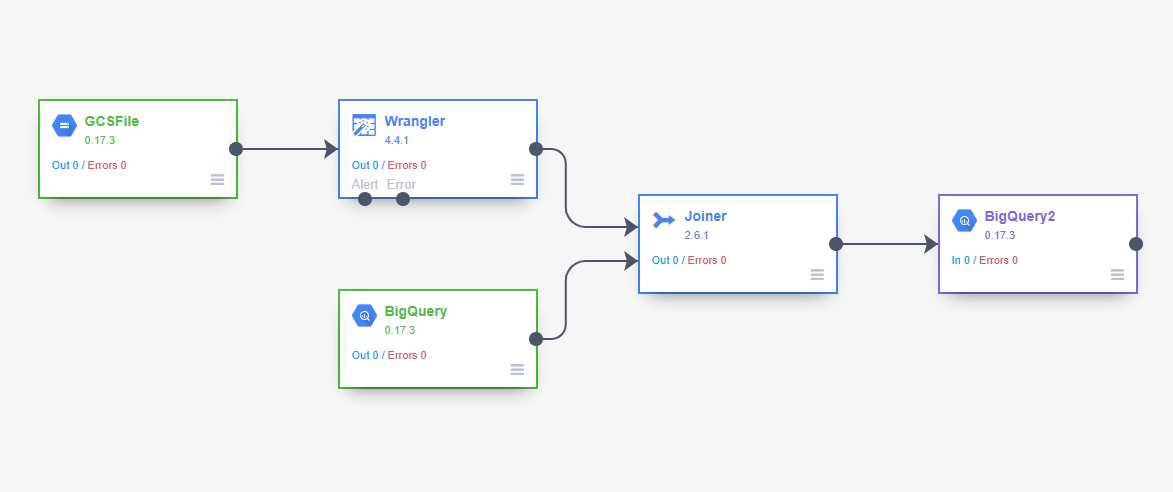

#<font color="red">**--------------------[Week2 - Day2]--------------------**

<font color='green'>**Video#2: Orchestrating work between GCP services with Cloud Composern**

- To run pipelines and work obs in a certain oreder, you need an orchestration engine
-  Cloud Composer is simply a serverless environment in which an open-source workflow tool runs.
- That workflow tool is called Apache Airflow, which is an open-source orchestration engine
- Airflow is a platform to programmatically author, schedule and monitor workflows. Use Airflow to author workflows as directed acyclic graphs (DAGs) of tasks. The airflow scheduler executes your tasks on an array of workers while following the specified dependencies.
- Workflow, DAG & pipeline are sometimes used interchangeable
- you can have multiple Cloud Composer environments and with each environment, you can have a separate Apache Airflow Instance, which could have zero to many DAGs. 
- The DAGs folder for each Airflow Instance is simply a GCS bucket that is automatically created for when you launch your Cloud Composer Instance and is where the code of your actual workflows will be stored
- Airflow workflows are writted in Python
- each DAG will have a python file
- There are two scheduling options for Cloud Composer: Event Based (such as a new data coming from a pub subtopic you've subscribed to), or Periodic. This is also thought of as push (trigger based) or Pull (schedule based)
- You can set a number of retries to run your pipeline in case it fails due to a transient bug, but sometimes if the pipeline keeps failing you need to look at the looks and debug
- You can moitor the status and logs of historical workflows and pipelines progress in the DAG runs
- Clcking on the schedule of any DAG takes you the DAG run page
- Another tool in your toolkit for diagnosing Airflow failures is the general GCP logs. Since Airflow launches other GCP services through tasks, you can see and filter for errors for those services and Stackdriver as you would debugging any other normal application

Glossary of terms/concepts used within Airflow:

**DAG**

A Directed Acyclic Graph is a collection of all the tasks you want to run, organized in a way that reflects their relationships and dependencies.

**Operator**

The description of a single task, it is usually atomic. For example, the BashOperator is used to execute bash command.

**Task**

A parameterised instance of an Operator; a node in the DAG.

**Task Instance**

A specific run of a task; characterized as: a DAG, a Task, and a point in time. It has an indicative state: running, success, failed, skipped, ...


Lab:

Steps:

- Ensure that the Kubernetes Engine API is successfully enabled

- Ensure that the Cloud Composer API is successfully enabled

- Create Cloud Composer environment

- Create a Cloud Storage bucket - This buckets will be used as output for the Hadoop job from Dataproc.

- Set Airflow variables: Select Admin > Variables from the Airflow menu bar, then Create ... Create the following Airflow variables, gcp_project, gcs_bucket, and gce_zone

- Upload the DAG to Cloud Storage

- Explore DAG runs

------------------------------

- In the cell below is an example workflow code, also referred to as a DAG. DAGs are defined in standard Python files that are placed in Airflow's DAG_FOLDER. Airflow will execute the code in each file to dynamically build the DAG objects. You can have as many DAGs as you want, each describing an arbitrary number of tasks. In general, each one should correspond to a single logical workflow.

To orchestrate the three workflow tasks, the DAG imports the following operators:

DataprocClusterCreateOperator: Creates a Cloud Dataproc cluster.
DataProcHadoopOperator: Submits a Hadoop wordcount job and writes results to a Cloud Storage bucket.
DataprocClusterDeleteOperator: Deletes the cluster to avoid incurring ongoing Compute Engine charges.

In [ ]:
"""Example Airflow DAG that creates a Cloud Dataproc cluster, runs the Hadoop
wordcount example, and deletes the cluster.

This DAG relies on three Airflow variables
https://airflow.apache.org/concepts.html#variables
* gcp_project - Google Cloud Project to use for the Cloud Dataproc cluster.
* gce_zone - Google Compute Engine zone where Cloud Dataproc cluster should be
  created.
* gcs_bucket - Google Cloud Storage bucket to used as output for the Hadoop jobs from Dataproc.
  See https://cloud.google.com/storage/docs/creating-buckets for creating a
  bucket.
"""

import datetime
import os

from airflow import models
from airflow.contrib.operators import dataproc_operator
from airflow.utils import trigger_rule

# Output file for Cloud Dataproc job.
output_file = os.path.join(
    models.Variable.get('gcs_bucket'), 'wordcount',
    datetime.datetime.now().strftime('%Y%m%d-%H%M%S')) + os.sep
# Path to Hadoop wordcount example available on every Dataproc cluster.
WORDCOUNT_JAR = (
    'file:///usr/lib/hadoop-mapreduce/hadoop-mapreduce-examples.jar'
)
# Arguments to pass to Cloud Dataproc job.
wordcount_args = ['wordcount', 'gs://pub/shakespeare/rose.txt', output_file]

yesterday = datetime.datetime.combine(
    datetime.datetime.today() - datetime.timedelta(1),
    datetime.datetime.min.time())

default_dag_args = {
    # Setting start date as yesterday starts the DAG immediately when it is
    # detected in the Cloud Storage bucket.
    'start_date': yesterday,
    # To email on failure or retry set 'email' arg to your email and enable
    # emailing here.
    'email_on_failure': False,
    'email_on_retry': False,
    # If a task fails, retry it once after waiting at least 5 minutes
    'retries': 1,
    'retry_delay': datetime.timedelta(minutes=5),
    'project_id': models.Variable.get('gcp_project')
}

with models.DAG(
        'composer_sample_quickstart',
        # Continue to run DAG once per day
        schedule_interval=datetime.timedelta(days=1),
        default_args=default_dag_args) as dag:

    # Create a Cloud Dataproc cluster.
    create_dataproc_cluster = dataproc_operator.DataprocClusterCreateOperator(
        task_id='create_dataproc_cluster',
        # Give the cluster a unique name by appending the date scheduled.
        # See https://airflow.apache.org/code.html#default-variables
        cluster_name='composer-hadoop-tutorial-cluster-{{ ds_nodash }}',
        num_workers=2,
        region='us-central1',
        zone=models.Variable.get('gce_zone'),
        image_version='2.0',
        master_machine_type='n1-standard-2',
        worker_machine_type='n1-standard-2')

    # Run the Hadoop wordcount example installed on the Cloud Dataproc cluster
    # master node.
    run_dataproc_hadoop = dataproc_operator.DataProcHadoopOperator(
        task_id='run_dataproc_hadoop',
        region='us-central1',
        main_jar=WORDCOUNT_JAR,
        cluster_name='composer-hadoop-tutorial-cluster-{{ ds_nodash }}',
        arguments=wordcount_args)

    # Delete Cloud Dataproc cluster.
    delete_dataproc_cluster = dataproc_operator.DataprocClusterDeleteOperator(
        task_id='delete_dataproc_cluster',
        region='us-central1',
        cluster_name='composer-hadoop-tutorial-cluster-{{ ds_nodash }}',
        # Setting trigger_rule to ALL_DONE causes the cluster to be deleted
        # even if the Dataproc job fails.
        trigger_rule=trigger_rule.TriggerRule.ALL_DONE)

    # Define DAG dependencies ... These tasks are run sequentially
    create_dataproc_cluster >> run_dataproc_hadoop >> delete_dataproc_cluster

#<font color="red">**--------------------[Week2 - Day2]--------------------**

<font color='green'>**Video1: Cloud Dataflow**

- Cloud Dataflow is the serverless execution service for data-processing pipelines written using Apache Beam.
- Apache Beam is open-source. You author your pipeline and then give it to a runner. Beam supports multiple runners like Flink and Spark if you wanted to run your Beam pipeline on-prem or in another Cloud. 

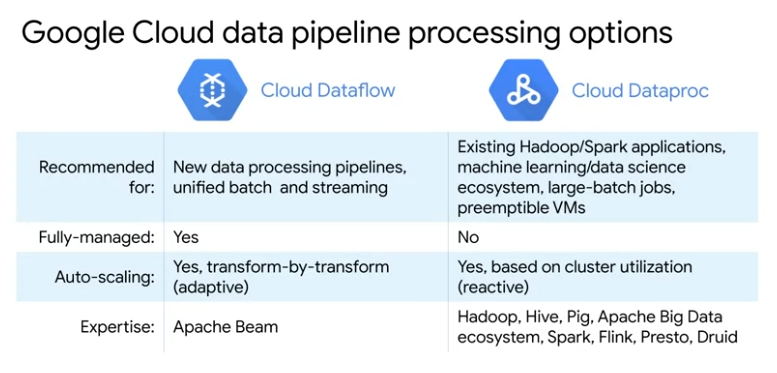

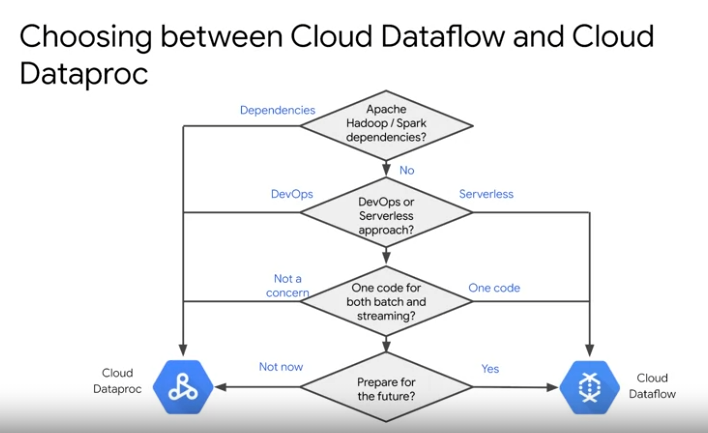

- Cloud Dataflow provides a serverless way to execute pipelines on batch and streaming data. Serverless means there are no servers for you to manage, the service just works. For example, if you have a ton of data to process, Dataflow will intelligently call upon more virtual machines to help. Since Dataflow also support streaming, this makes your pipeline low-latency, meaning you can process data as soon as it comes in. 

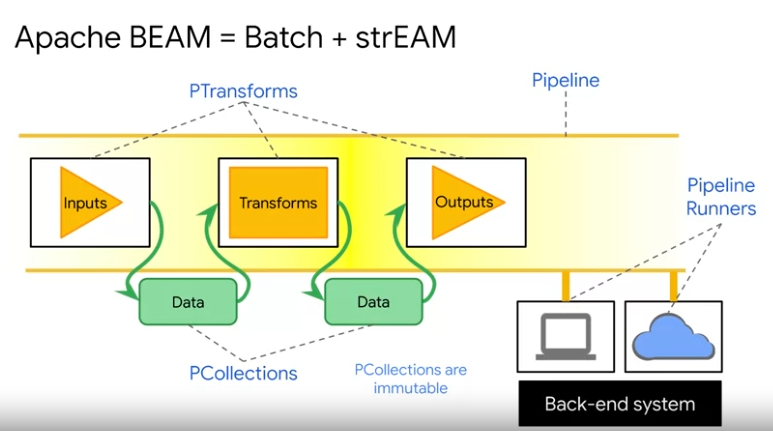

- A pipeline identifies the data to be processed and the actions to be taken on the data. The data is held in a distributed data abstraction called a Pcollection. The Pcollection is immutable. Any change that happens in a pipeline and just one Pcollection and creates a new one. It does not change the incoming Pcollection. The actions or code is contained in an abstraction called a Ptransform. The Ptransform handles input, transformations, and output of the data. The data in a Pcollection is passed along the graph from one Ptransform to another. Pipeline runners are analogous to container home such as Kubernetes Engine. The identical pipeline can be run on a local computer, datacenter VM or on a service such as Cloud Dataflow in the Cloud. The only difference is scale and access to the platform specific services. The services that Runner uses to execute the code is called a backend system.

- A Pcollection represents both streaming data and batch data. There's no size limits your Pcollection either bounded or unbounded. That's why it's called a Pcollection or parallel collection. The more data, the more it's simply distributed in parallel across more workers. For streaming data, the Pcollection is simply without bounds. It has no end. Each element inside a Pcollection can be individually accessed and processed. 

- the advantages of Dataflow are first, Dataflow is fully managed and auto configured. You just deploy your pipeline. Second, Dataflow doesn't just execute Apache Beam transforms as is, it optimizes the graph, fusing operations efficiently. Also, it doesn't wait for a previous step to finish before starting a new step, as long as there is no dependency. Third, autoscaling happens step by step in the middle of a job. As a job needs more resources, it receives more resources automatically. You don't have to manually scale resources to match job needs, and you don't pay for VM resources that aren't being used. Dataflow will turn down the workers, as the job demand decrease. All this happens while maintaining strong streaming semantics. Aggregations, like sums and counts, are correct even if the input source sends duplicate records. Dataflow is also able to handle late arriving records with intelligent watermarking. Finally, Dataflow functions as the glue that ties together many of the services on GCP, it's interoperable. Do you need to read data from BigQuery and write to Bigtable? Use Dataflow. Do you need to read from pub/sub and write to Cloud SQL? Yes, use Dataflow.

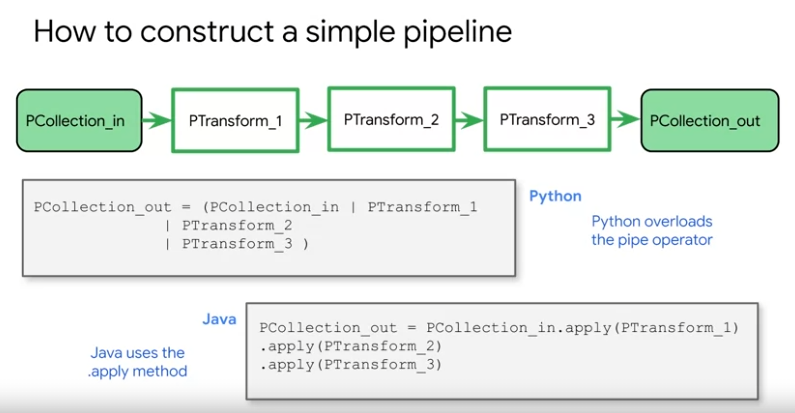

create a PCollection by taking the pipeline object P, and passing it over a text file in Google Cloud storage, that's the read from text line. Then, we apply the PTransform called FlatMap to the lines read from the text file. What FlatMap does, is applies a function to each row of the input and concatenate all of the outputs. When the function is applied to a row, it may return zero or more elements that go to the output PCollection. The function in this case, is a function called CountWords. It takes the line of texts and returns an integer. The output PCollection then consists of a set of integers. These integers are written to a text file and Google Cloud storage

- Because the pipeline was created in a with clause, and because this is not a streaming pipeline, exiting the with clause automatically stops the pipeline


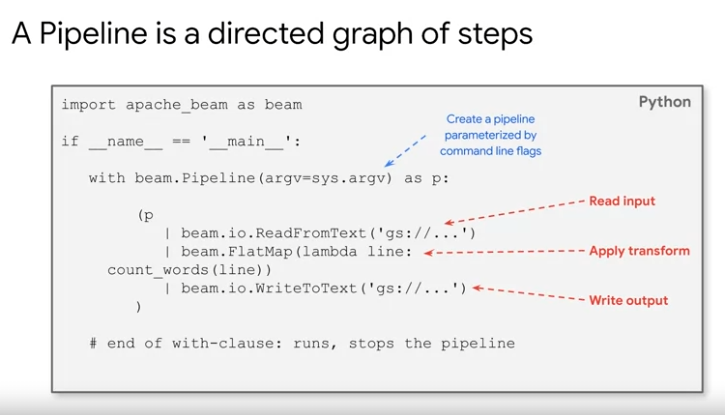

- Executing the Python program on the previous slide, will run that program. By default, the program is run using the default runner, which runs on the same machine that the Python program was executed on. When you create the pipeline, you can pass in a set of options as you see here. One of these options is the runner. Here we've chosen Dataflow, which will have the pipeline run on Google Cloud. Of course, normally, you'll setup command line parameters to transparently switch between local and Cloud. Calling the file locally, will run at local and adding Cloud parameters will submit the job to the Cloud.

- 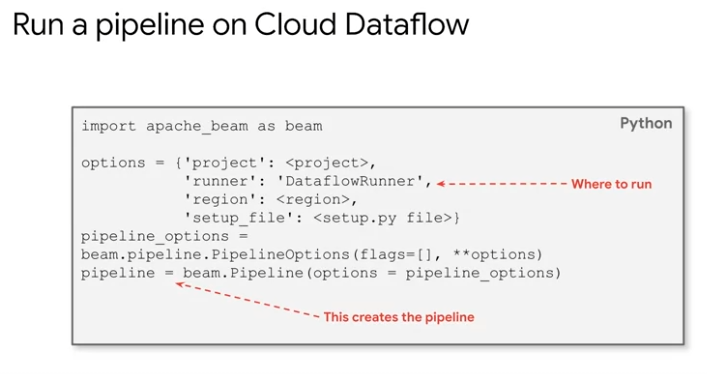

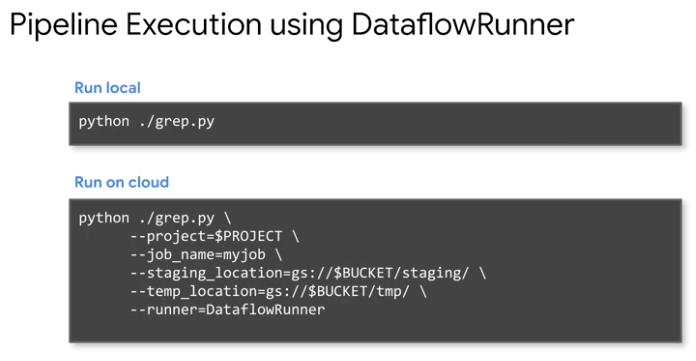

<font color='green'>**Video#4: Key considerations with designing pipelines

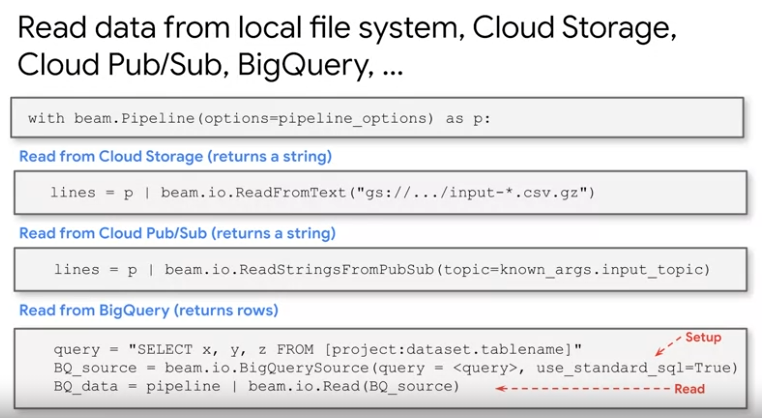